# Import

In [83]:
import numpy as np
import pandas as pd
# from PFPM import Mining_Periodic_Frequent_Patterns
import ast
import graphviz
from collections import Counter
import matplotlib.pyplot as plt
import time
# from memory_profiler import profile

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model

In [85]:
class Node:
    def __init__(self, name, parent=None):
        self.name = name
        self.CID = []
        self.parent = parent
        self.children = {}

    def visualize_tree_graphviz(self):
        dot = graphviz.Digraph(comment='Tree Structure')

        def _add_nodes(node):
            # Add node with label including name, and comma-separated transaction IDs
            label = f"{node.name} ( CID: {','.join(str(t) for t in node.CID)})"
            dot.node(str(id(node)), label)

            for child_name, child_node in node.children.items():
                dot.edge(str(id(node)), str(id(child_node)))
                _add_nodes(child_node)

        _add_nodes(self)
        dot.render('tree.gv', view=True)
        return dot


In [86]:
def build_SPP_list(database, minSup, maxPer, maxLa):
    SPP_list = {}
    c_last = {}  # Temporary array to store the CID
    ML = {}     # Maximum lability for each item
    la = {}     # Lability for each item
    support = {}  # Support for each item

    for tcur, cart in enumerate(database):
        for item in cart:
            if item not in c_last:
                c_last[item] = 1
                ML[item] = 1
                la[item] = 1
                support[item] = 1
            else:
                support[item] += 1
                la[item] = max(0, la[item] + tcur - c_last[item] - maxPer)
                ML[item] = max(ML[item], la[item])
                c_last[item] = tcur

    for item, sup in support.items():
        if sup >= minSup and ML[item] <= maxLa:
            SPP_list[item] = sup

    SPP_list = dict(sorted(SPP_list.items(), key=lambda x: x[1], reverse=True))
    return SPP_list

In [87]:
class SPP_Tree:
    def __init__(self,root="root"):
        self.root = Node(root)
        self.header_table = {}

    def update_header_table(self, node, item):
        if item in node.parent.children:
            current_node = node.parent.children[item]
            while item in self.header_table and self.header_table[item] != current_node: # Use self.header_table
                current_node = self.header_table[item]
            if item not in self.header_table:
                self.header_table[item] = set()
                self.header_table[item].add(node)
            else:
                self.header_table[item].add(node)

    def insert_tree(self, items, tcur, node):
        if items[0] not in node.children:
          new_node = Node(items[0], parent=node)
          node.children[items[0]] = new_node

          self.update_header_table(new_node, items[0])

        if len(items) > 1:
            self.insert_tree(items[1:], tcur, node.children[items[0]])
        elif len(items) == 1:
            node.children[items[0]].CID.append(tcur+1)
        else:
          return


    def build_tree(self, database, SPP_list):
        # Build the SPP tree
        tcur = 0
        for cart in database:
            tcur += 1
            sorted_items = [item for item in cart if item in SPP_list]
            if sorted_items: # Check if sorted_items is not empty before inserting
                sorted_items.sort(key=lambda x: SPP_list[x], reverse=True)
                self.insert_tree(sorted_items, tcur, self.root)
        return self.header_table, self.root




In [88]:
class Mining_SPP_tree:
    def __init__(self, spp_tree, alpha):
        self.spp_tree = spp_tree
        self.alpha = alpha

    def get_conditional_patterns(self, suffix):
      prefix = set()
      for leaf in spp_tree.header_table[suffix]:
          if leaf.parent.name != 'root':
              node = leaf
              while node.parent is not None:
                  prefix.add(node.name)
                  node = node.parent
      return prefix
    def run_algorithm(self, minSup=10, maxPer=80, maxL=80):
        conditional_patterns = []
        header_table = self.spp_tree.header_table.copy()
        while header_table:
              i = next(iter(header_table))
              suffix = (self.alpha | {i}).pop()

              prefix = self.get_conditional_patterns(suffix)
              conditional_patterns.append(list(prefix))
              del header_table[suffix]

        spp_tree  = SPP_Tree()
        SPP_list_beta = build_SPP_list(conditional_patterns, minSup, maxPer, maxLa)

        # Build initial SPP tree beta
        header_table, tree_beta_root = spp_tree.build_tree(conditional_patterns, SPP_list)

        return SPP_list_beta, conditional_patterns, tree_beta_root

# Dataset 1

## Prepare dataset 1

In [89]:
dataset1 = pd.read_csv("/content/drive/MyDrive/IT Project/Code/dataset/dataset1.csv")

In [90]:
dataset1['Date'] = pd.to_datetime(dataset1['Date'])

df_spring = dataset1[(dataset1['Date'].dt.month >= 3) & (dataset1['Date'].dt.month <= 5) & (dataset1['Date'].dt.year == 2011)]
df_summer = dataset1[(dataset1['Date'].dt.month >= 6) & (dataset1['Date'].dt.month <= 8) & (dataset1['Date'].dt.year == 2011)]
df_autumn = dataset1[(dataset1['Date'].dt.month >= 9) & (dataset1['Date'].dt.month <= 11) & (dataset1['Date'].dt.year == 2011)]
df_winter = dataset1[((dataset1['Date'].dt.month >= 12) | (dataset1['Date'].dt.month <= 2)) & (dataset1['Date'].dt.year == 2011)]

In [91]:
# winter_dataset = df_winter["Description"].apply(ast.literal_eval).apply(lambda x: x[-10:]).tolist()

winter_dataset = df_winter["Description"].apply(ast.literal_eval).tolist()
autumn_dataset = df_autumn["Description"].apply(ast.literal_eval).tolist()
summer_dataset = df_summer["Description"].apply(ast.literal_eval).tolist()
spring_dataset = df_spring["Description"].apply(ast.literal_eval).tolist()

In [92]:
sorted_winter_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in winter_dataset]
sorted_autumn_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in autumn_dataset]
sorted_summer_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in summer_dataset]
sorted_spring_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in spring_dataset]

##Traning

In [93]:
start_time = time.time()

{'C3376': 520, 'C560': 481, 'C1124': 469, 'C3533': 353, 'C1035': 336, 'C2191': 325, 'C2485': 317, 'C2873': 301}
[['C3533', 'C1124', 'C560', 'C1035', 'C2485', 'C3376', 'C2191'], ['C3376'], ['C560', 'C3376'], ['C3533', 'C1124', 'C560', 'C1035', 'C3376'], ['C3533', 'C1124', 'C2873', 'C560', 'C1035', 'C2485', 'C3376', 'C2191'], ['C3533', 'C1124', 'C560', 'C1035', 'C3376', 'C2191'], ['C560', 'C3376', 'C1124'], ['C560', 'C3376', 'C3533', 'C1124']]


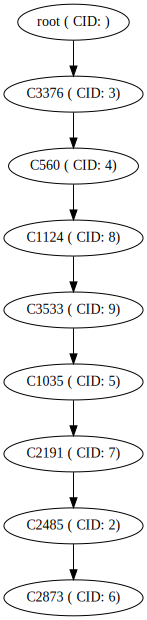

In [94]:
minSup = 300
maxPer = 80
maxLa = 10


spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_spring_dataset, minSup, maxPer, maxLa)
SPP_list_spring_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_spring_dataset, SPP_list)

# print(SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)

tree_beta_root.visualize_tree_graphviz()

{'C560': 452, 'C3620': 450, 'C1035': 409, 'C3376': 398, 'C2191': 385, 'C1997': 355, 'C1124': 350}
[['C560'], ['C1997', 'C1124', 'C560', 'C1035', 'C3376', 'C3620', 'C2191'], ['C560', 'C3620'], ['C1997', 'C560', 'C1035', 'C3376', 'C3620', 'C2191'], ['C560', 'C3620', 'C3376', 'C1035'], ['C560', 'C3620', 'C1035'], ['C560', 'C1035', 'C3376', 'C3620', 'C2191']]


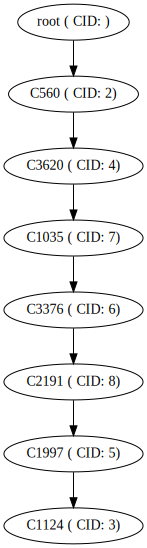

In [95]:
minSup = 350
maxPer = 80
maxLa = 10

spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_summer_dataset, minSup, maxPer, maxLa)
SPP_list_summer_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_summer_dataset, SPP_list)

# print(SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)


tree_beta_root.visualize_tree_graphviz()

{'C1974': 698, 'C1692': 635, 'C1035': 559, 'C3376': 539, 'C960': 492, 'C3533': 486, 'C1439': 483, 'C129': 468}
[['C1974', 'C3376', 'C1035', 'C1692'], ['C1974', 'C1692'], ['C1974'], ['C1974', 'C960', 'C1692', 'C1035', 'C3376'], ['C1974', 'C1035', 'C1692'], ['C1974', 'C3533', 'C960', 'C1692', 'C1035', 'C3376'], ['C1974', 'C1439', 'C3533', 'C960', 'C1692', 'C1035', 'C129', 'C3376'], ['C1974', 'C1439', 'C3533', 'C960', 'C1692', 'C1035', 'C3376']]


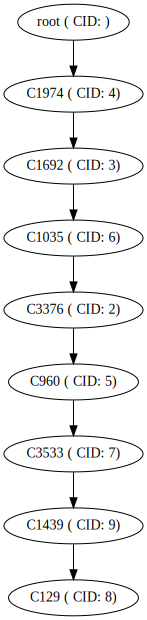

In [96]:
minSup = 450
maxPer = 100
maxLa = 10

spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_autumn_dataset, minSup, maxPer, maxLa)
SPP_list_autumn_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# print(sup, minSup, ML[item], maxLa)

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_autumn_dataset, SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)


tree_beta_root.visualize_tree_graphviz()

{'C3376': 383, 'C1594': 317, 'C1124': 310, 'C1894': 267, 'C1035': 245, 'C748': 234, 'C176': 226, 'C3533': 224, 'C3642': 223, 'C3358': 212, 'C407': 211, 'C2191': 208, 'C1968': 200, 'C2009': 200}
{'C3376': 383, 'C1594': 317, 'C1124': 310, 'C1894': 267, 'C1035': 245, 'C748': 234, 'C176': 226, 'C3533': 224, 'C3642': 223, 'C3358': 212, 'C407': 211, 'C2191': 208, 'C1968': 200, 'C2009': 200}
[['C3376'], ['C1124', 'C1035', 'C1594', 'C1894', 'C3376'], ['C1594', 'C3376'], ['C1124', 'C1035', 'C1594', 'C748', 'C1894', 'C3376'], ['C1594', 'C3376', 'C1124'], ['C3533', 'C1124', 'C1035', 'C1594', 'C748', 'C176', 'C1894', 'C3376'], ['C3533', 'C1124', 'C1035', 'C1594', 'C748', 'C3642', 'C176', 'C1894', 'C3376'], ['C3533', 'C1124', 'C3358', 'C407', 'C1035', 'C1594', 'C748', 'C3642', 'C176', 'C1894', 'C3376', 'C2191'], ['C3533', 'C1968', 'C1124', 'C3358', 'C1035', 'C407', 'C1594', 'C748', 'C3642', 'C176', 'C1894', 'C3376', 'C2191'], ['C3533', 'C1124', 'C3358', 'C407', 'C1035', 'C2009', 'C1594', 'C3376', '

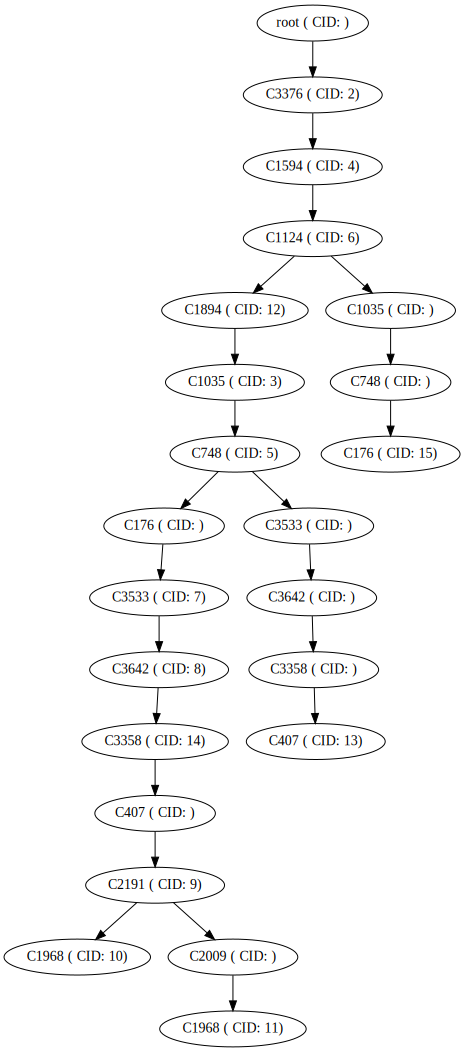

In [97]:
minSup = 200
maxPer = 150
maxLa = 10


spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_winter_dataset, minSup, maxPer, maxLa)
SPP_list_winter_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_winter_dataset, SPP_list)

print(SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)


tree_beta_root.visualize_tree_graphviz()

In [98]:
end_time = time.time()
# Tính toán thời gian thực thi
execution_time = end_time - start_time
print(f"Thời gian thực thi: {execution_time} giây")

Thời gian thực thi: 0.7608401775360107 giây


## Analysis OutPut

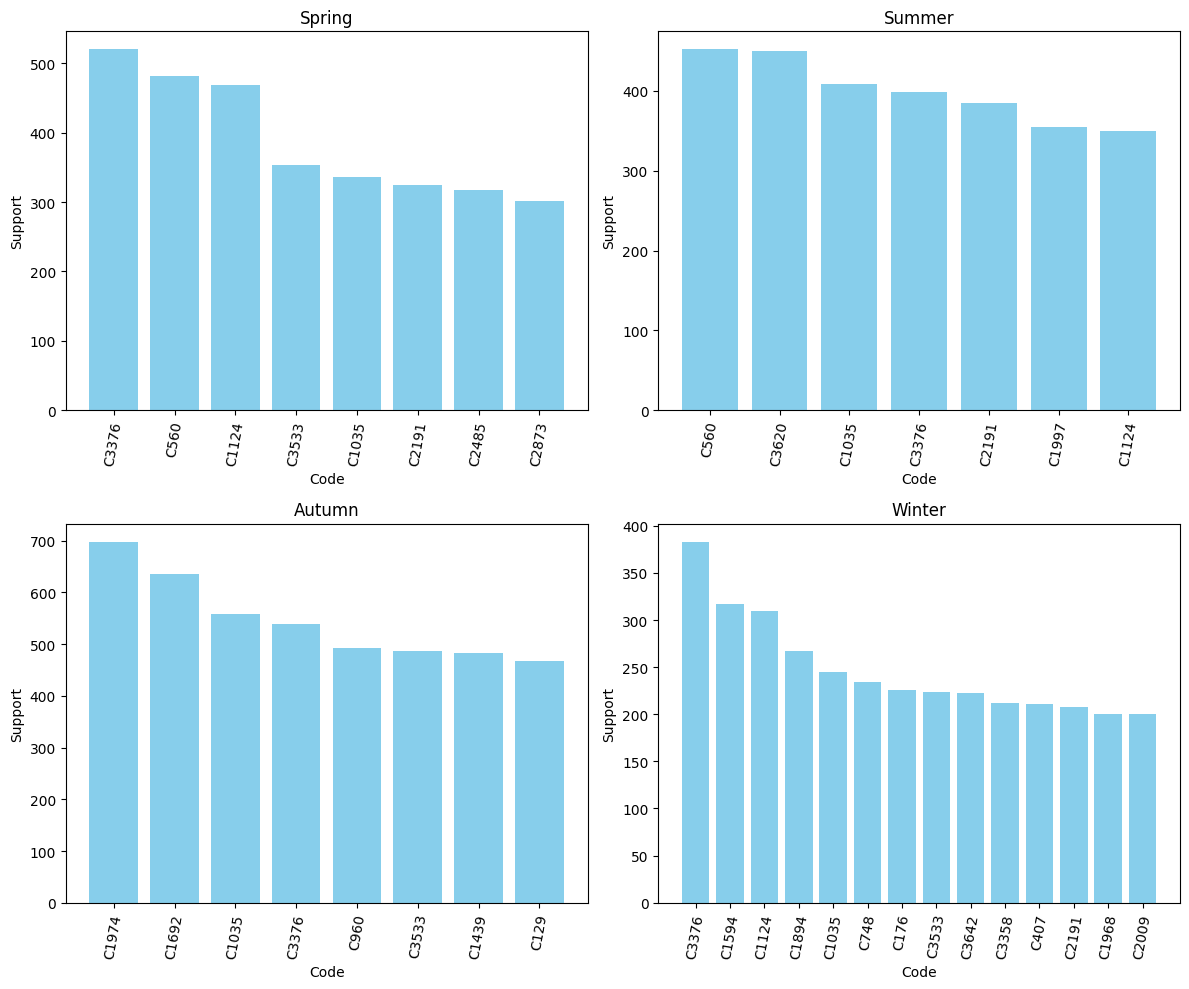

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [SPP_list_spring_df, SPP_list_summer_df, SPP_list_autumn_df, SPP_list_winter_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='Support', ascending=False))
    ax.bar(df['Code'], df['Support'], color='skyblue')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Support')
    ax.tick_params(axis='x', rotation=80)
plt.tight_layout()
plt.show()

## Evaluate model

In [100]:
top_n = 10

In [101]:
# ## winter
winter_dataset_counts = Counter([item for sublist in winter_dataset for item in sublist]).most_common(top_n)
winter_dataset_counts_df = pd.DataFrame(winter_dataset_counts, columns=['Code', 'Quantity'])


# ## autumn
autumn_dataset_counts = Counter([item for sublist in autumn_dataset for item in sublist]).most_common(top_n)
autumn_dataset_counts_df = pd.DataFrame(autumn_dataset_counts, columns=['Code', 'Quantity'])


## summer
summer_dataset_counts = Counter([item for sublist in summer_dataset for item in sublist]).most_common(top_n)
summer_dataset_counts_df = pd.DataFrame(summer_dataset_counts, columns=['Code', 'Quantity'])


### spring
spring_dataset_counts = Counter([item for sublist in spring_dataset for item in sublist]).most_common(top_n)
spring_dataset_counts_df = pd.DataFrame(spring_dataset_counts, columns=['Code', 'Quantity'])



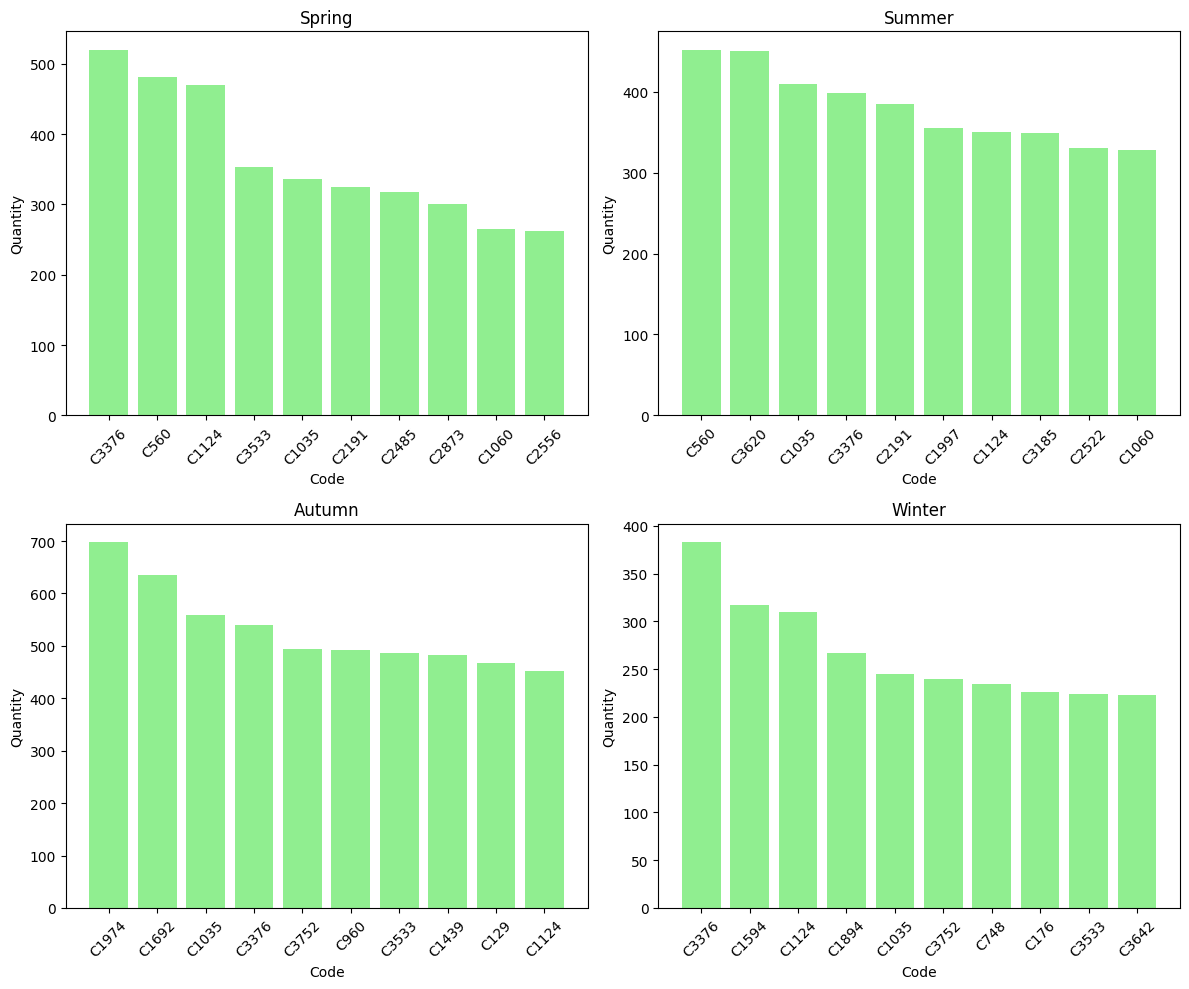

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [spring_dataset_counts_df, summer_dataset_counts_df, autumn_dataset_counts_df, winter_dataset_counts_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='Quantity', ascending=False))
    ax.bar(df['Code'], df['Quantity'], color='lightgreen')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Quantity')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

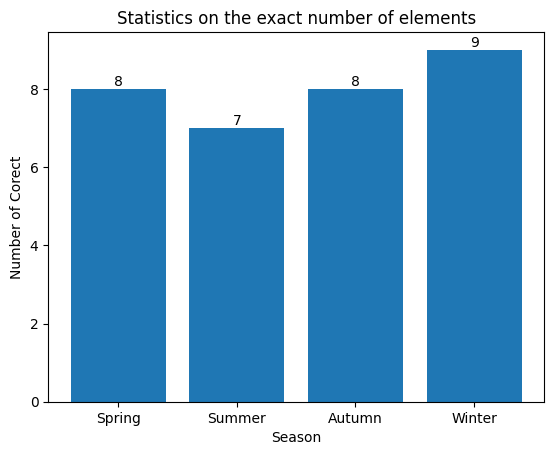

In [103]:
confident_spring = list(set(spring_dataset_counts_df['Code']).intersection(set(SPP_list_spring_df['Code'])))
confident_summer = list(set(summer_dataset_counts_df['Code']).intersection(set(SPP_list_summer_df['Code'])))
confident_autumn = list(set(autumn_dataset_counts_df['Code']).intersection(set(SPP_list_autumn_df['Code'])))
confident_winter = list(set(winter_dataset_counts_df['Code']).intersection(set(SPP_list_winter_df['Code'])))

counts = [len(confident_spring), len(confident_summer), len(confident_autumn), len(confident_winter)]

# Vẽ biểu đồ cột
plt.bar(['Spring', 'Summer', 'Autumn', 'Winter'], counts)

# Add labels on top of each bar
plt.bar_label(plt.gca().containers[0])

plt.xlabel('Season')
plt.ylabel('Number of Corect')
plt.title('Statistics on the exact number of elements')
plt.show()



In [123]:
confident_dataset1 = sum([len(confident_spring)/top_n, len(confident_summer)/top_n, len(confident_autumn)/top_n, len(confident_winter)/top_n]) / 4

In [124]:
confident_dataset1

0.7999999999999999

# Dataset 2

## Prepare dataset 2

In [106]:
dataset2 = pd.read_csv("/content/drive/MyDrive/IT Project/Code/dataset/dataset2.csv")

In [107]:
dataset2['Date'] = pd.to_datetime(dataset2['Date'])

df_spring = dataset2[(dataset2['Date'].dt.month >= 3) & (dataset2['Date'].dt.month <= 5)]
df_summer = dataset2[(dataset2['Date'].dt.month >= 6) & (dataset2['Date'].dt.month <= 8)]
df_autumn = dataset2[(dataset2['Date'].dt.month >= 9) & (dataset2['Date'].dt.month <= 11)]
df_winter = dataset2[(dataset2['Date'].dt.month >= 12) | (dataset2['Date'].dt.month <= 2)]


In [108]:
winter_dataset = df_winter["Description"].apply(ast.literal_eval).tolist()
autumn_dataset = df_autumn["Description"].apply(ast.literal_eval).tolist()
summer_dataset = df_summer["Description"].apply(ast.literal_eval).tolist()
spring_dataset = df_spring["Description"].apply(ast.literal_eval).tolist()

In [109]:
sorted_winter_dataset2 = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in winter_dataset]
sorted_autumn_dataset2 = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in autumn_dataset]
sorted_summer_dataset2 = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in summer_dataset]
sorted_spring_dataset2 = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in spring_dataset]

##Traning

In [110]:
start_time = time.time()

{'C1382': 27, 'C3323': 22, 'C788': 19, 'C2611': 19, 'C3716': 19, 'C3087': 19, 'C54': 18, 'C2214': 18}
{'C1382': 27, 'C3323': 22, 'C788': 19, 'C2611': 19, 'C3716': 19, 'C3087': 19, 'C54': 18, 'C2214': 18}
[[], ['C1382', 'C3323'], ['C788', 'C1382', 'C3323'], ['C788', 'C2611', 'C1382', 'C3323'], ['C2611', 'C3087', 'C1382', 'C3716', 'C788', 'C3323'], ['C2611', 'C3087', 'C1382', 'C54', 'C3716', 'C788', 'C3323'], ['C2611', 'C3087', 'C1382', 'C788', 'C3323'], ['C2611', 'C3087', 'C2214', 'C1382', 'C54', 'C3716', 'C788', 'C3323']]


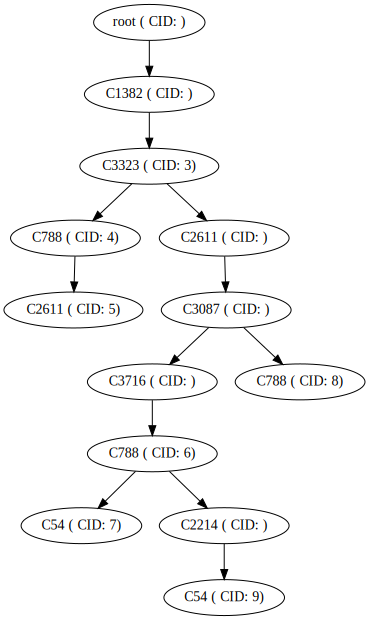

In [111]:
minSup = 18
maxPer = 50
maxLa = 20


spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_winter_dataset2, minSup, maxPer, maxLa)
SPP_list_winter_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_winter_dataset2, SPP_list)

print(SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)


tree_beta_root.visualize_tree_graphviz()

{'C1446': 58, 'C2321': 32, 'C1382': 29, 'C3323': 28, 'C3716': 28, 'C1934': 27, 'C2166': 25, 'C54': 25, 'C3087': 24, 'C2214': 23}
[['C1446'], ['C1446', 'C2321'], [], ['C1382', 'C3323'], ['C1382', 'C3323', 'C3716'], ['C3323', 'C1382', 'C1934', 'C3716'], ['C1382', 'C54', 'C3716', 'C2166', 'C1934', 'C3323'], ['C3087', 'C1382', 'C54', 'C3716', 'C1934', 'C2166', 'C3323'], ['C3087', 'C2214', 'C54', 'C1382', 'C3716', 'C1934', 'C2166', 'C3323'], ['C1382', 'C54', 'C3716', 'C1934', 'C3323']]


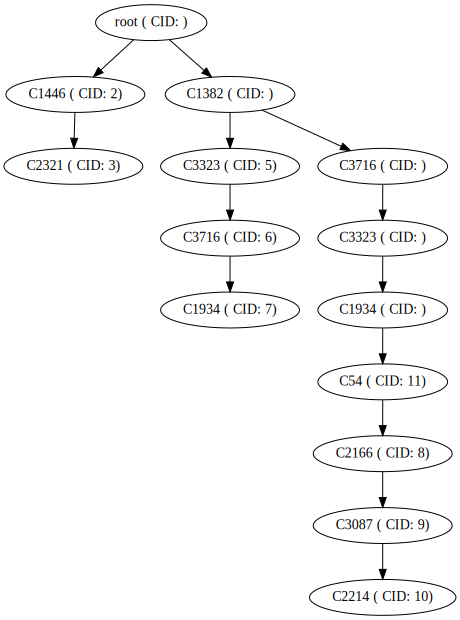

In [112]:
minSup = 22
maxPer = 100
maxLa = 10


spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_spring_dataset2, minSup, maxPer, maxLa)
SPP_list_spring_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_spring_dataset2, SPP_list)

# print(SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)


tree_beta_root.visualize_tree_graphviz()

{'C1446': 46, 'C1934': 26, 'C54': 24, 'C2483': 21, 'C1382': 21, 'C3716': 21, 'C3677': 18, 'C2214': 17, 'C1322': 16, 'C644': 16}
[['C1446'], ['C2483', 'C1446'], ['C54', 'C1934'], ['C1382', 'C54', 'C1934'], ['C1382', 'C54', 'C1934', 'C3716'], ['C2214', 'C54', 'C1382', 'C3716', 'C1934', 'C3677'], ['C644', 'C1382', 'C54', 'C2214', 'C3716', 'C1934', 'C1322', 'C3677'], [], ['C1382', 'C54', 'C3716', 'C1934', 'C3677'], ['C644', 'C2214', 'C1382', 'C54', 'C3716', 'C1934', 'C3677']]


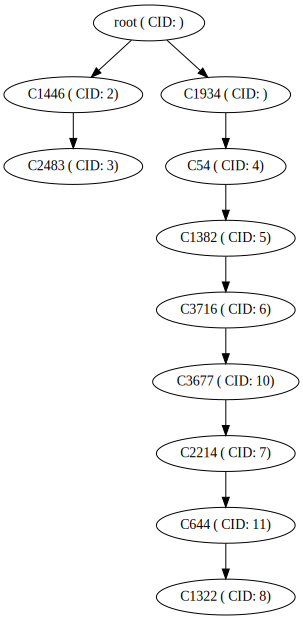

In [113]:
minSup = 16
maxPer = 35
maxLa = 10

spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_summer_dataset2, minSup, maxPer, maxLa)
SPP_list_summer_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_summer_dataset2, SPP_list)

# print(SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)

tree_beta_root.visualize_tree_graphviz()

{'C1382': 17, 'C54': 15, 'C3323': 15, 'C263': 15, 'C3716': 14, 'C3721': 11, 'C2611': 11, 'C2444': 10, 'C956': 10, 'C2701': 10}
[[], ['C1382', 'C54'], [], ['C54', 'C1382', 'C263', 'C3323'], ['C1382', 'C54', 'C3716', 'C263', 'C3323'], ['C2611', 'C3721'], ['C2611', 'C3721', 'C956'], ['C2611', 'C3721', 'C2701', 'C956'], ['C54', 'C1382', 'C263'], ['C2611', 'C1382', 'C54', 'C3716', 'C263', 'C3323']]


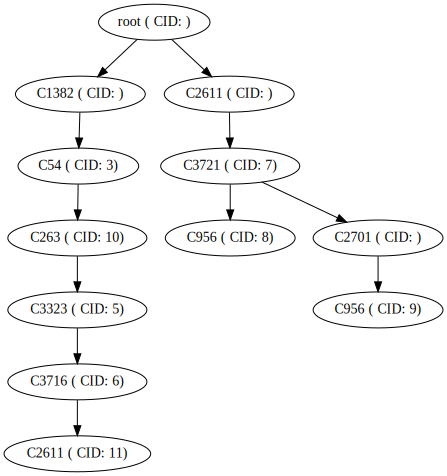

In [114]:
minSup = 10
maxPer = 20
maxLa = 10


spp_tree  = SPP_Tree()
SPP_list = build_SPP_list(sorted_autumn_dataset2, minSup, maxPer, maxLa)
SPP_list_autumn_df = pd.DataFrame(SPP_list.items(), columns=['Code', 'Support'])

# print(sup, minSup, ML[item], maxLa)

# Build initial SPP tree
header_table, tree_root  = spp_tree.build_tree(sorted_autumn_dataset2, SPP_list)

# Áp dụng thuật toán SPP-Growth
alpha = set()
model = Mining_SPP_tree(spp_tree, alpha)

SPP_list_beta, conditional_patterns, tree_beta_root = model.run_algorithm(minSup=10, maxPer=80, maxL=80)
print(SPP_list)
print(conditional_patterns)

tree_beta_root.visualize_tree_graphviz()

In [115]:
end_time = time.time()
# Tính toán thời gian thực thi
execution_time = end_time - start_time
print(f"Thời gian thực thi: {execution_time} giây")

Thời gian thực thi: 0.3303520679473877 giây


## Analysis OutPut

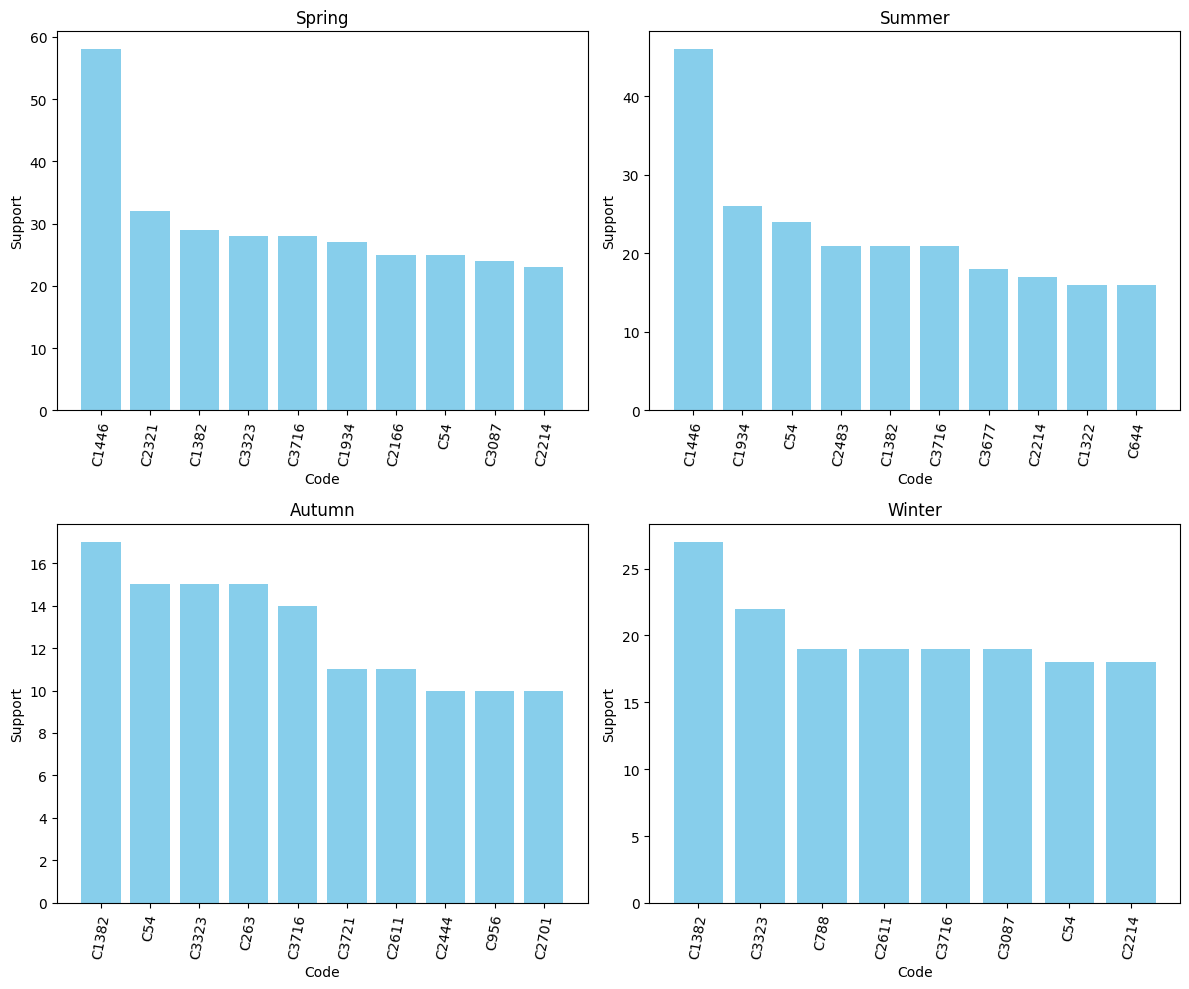

In [116]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [SPP_list_spring_df, SPP_list_summer_df, SPP_list_autumn_df, SPP_list_winter_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='Support', ascending=False))
    ax.bar(df['Code'], df['Support'], color='skyblue')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Support')
    ax.tick_params(axis='x', rotation=80)
plt.tight_layout()
plt.show()

## Evaluate

In [117]:
### winter
winter_dataset_counts = Counter([item for sublist in winter_dataset for item in sublist]).most_common(top_n)
winter_dataset_counts_df = pd.DataFrame(winter_dataset_counts, columns=['Code', 'Quantity'])


# ## autumn
autumn_dataset_counts = Counter([item for sublist in autumn_dataset for item in sublist]).most_common(top_n)
autumn_dataset_counts_df = pd.DataFrame(autumn_dataset_counts, columns=['Code', 'Quantity'])


## summer
summer_dataset_counts = Counter([item for sublist in summer_dataset for item in sublist]).most_common(top_n)
summer_dataset_counts_df = pd.DataFrame(summer_dataset_counts, columns=['Code', 'Quantity'])


### spring
spring_dataset_counts = Counter([item for sublist in spring_dataset for item in sublist]).most_common(top_n)
spring_dataset_counts_df = pd.DataFrame(spring_dataset_counts, columns=['Code', 'Quantity'])



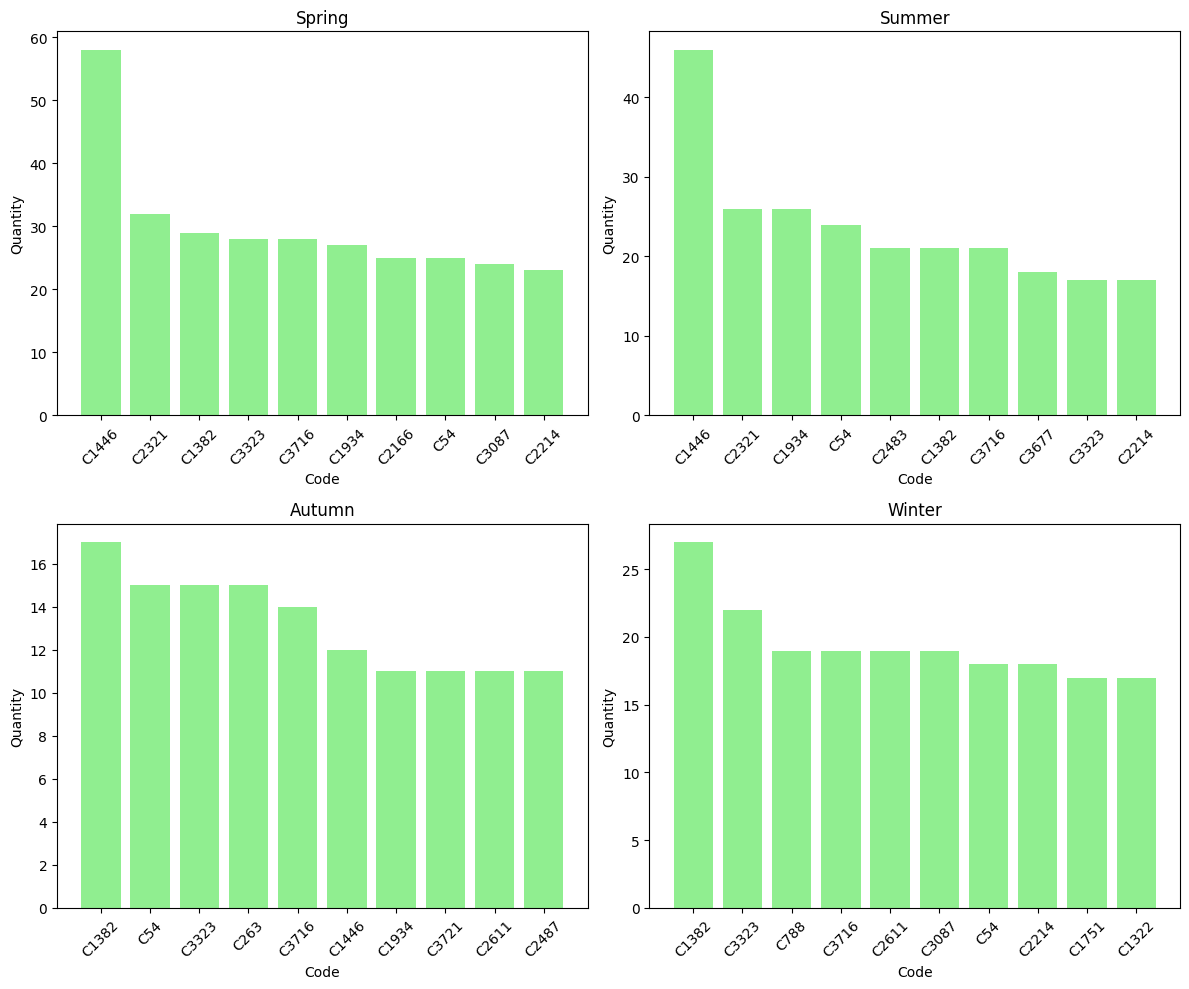

In [118]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [spring_dataset_counts_df, summer_dataset_counts_df, autumn_dataset_counts_df, winter_dataset_counts_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='Quantity', ascending=False))
    ax.bar(df['Code'], df['Quantity'], color='lightgreen')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Quantity')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

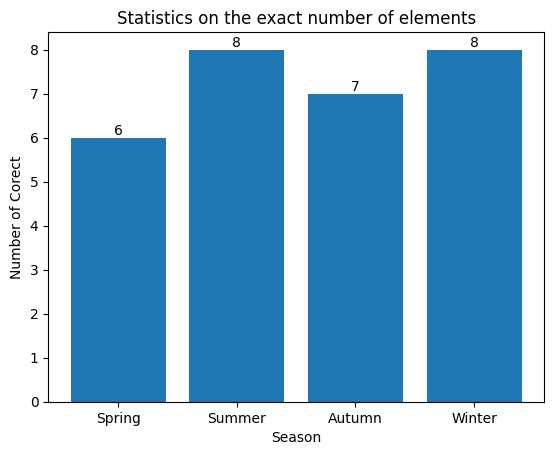

In [125]:
confident_spring_2022 = list(set(winter_dataset_counts_df['Code']).intersection(set(SPP_list_spring_df['Code'])))
confident_summer_2022 = list(set(summer_dataset_counts_df['Code']).intersection(set(SPP_list_summer_df['Code'])))
confident_autumn_2022 = list(set(autumn_dataset_counts_df['Code']).intersection(set(SPP_list_autumn_df['Code'])))
confident_winter_2022 = list(set(winter_dataset_counts_df['Code']).intersection(set(SPP_list_winter_df['Code'])))


counts = [len(confident_spring_2022), len(confident_summer_2022), len(confident_autumn_2022), len(confident_winter_2022)]

# Vẽ biểu đồ cột
plt.bar(['Spring', 'Summer', 'Autumn', 'Winter'], counts)

# Add labels on top of each bar
plt.bar_label(plt.gca().containers[0])

plt.xlabel('Season')
plt.ylabel('Number of Corect')
plt.title('Statistics on the exact number of elements')
plt.show()


confident_dataset2 = sum([len(confident_spring), len(confident_summer), len(confident_autumn), len(confident_winter)]) /  4



In [126]:
confident_dataset2

8.0